# Residual analysis for model debugging**

This notebook uses variants of residual analysis to find error mechanisms and security vulnerabilities and to assess stability and fairness in a trained XGBoost model. It begins by loading the UCI credit card default data and then training an interpretable, monotonically constrained XGBoost gradient boosting machine (GBM) model. (Pearson correlation with the prediction target is used to determine the direction of the monotonicity constraints for each input variable.) After the model is trained, its logloss residuals are analyzed and explained thoroughly and the constrained GBM is compared to a benchmark linear model. These model debugging exercises uncover several accuracy, drift, and security problems such as over-emphasis of important variables and strong signal in model residuals. Several remediation mechanisms are proposed including missing value injection during training, additional data collection, and use of assertions to correct known problems during scoring. 

#### Python imports 

In [1]:
import numpy as np                   # array, vector, matrix calculations
import os                            # file-handling
import pandas as pd                  # DataFrame handling
import shap                          # for consistent, signed variable importance measurements
import xgboost as xgb                # gradient boosting machines (GBMs)
import subprocess                    # manage external processes

import h2o                                                        # import h2o python bindings to java server
from h2o.backend import H2OLocalServer                            # for plotting local tree in-notebook
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
from h2o.estimators.glm import H2OGeneralizedLinearEstimator      # for benchmark model
from h2o.grid.grid_search import H2OGridSearch                    # for benchmark model

# plotting ###########
import matplotlib.pyplot as plt                                   # general plotting
from matplotlib.lines import Line2D                               # necessary for custom legends
import seaborn as sns                                             # facet grid for residuals
from mpl_toolkits import mplot3d                                  # 3-D scatterplots
import matplotlib; matplotlib.rcParams.update({'font.size': 40})  # set legible font size


# enables display of plots in notebook
# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

pd.options.display.max_columns = 999 # enable display of all dataframe columns in notebook

SEED = 12345                         # global random seed
np.random.seed(SEED)                 # set random seed for reproducibility
h2o.init()                           # start h2o java server

/Users/ngill/Desktop/interpretable-ml/iml/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,48 mins 38 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,"1 year, 2 months and 10 days !!!"
H2O cluster name:,H2O_from_python_ngill_fd277r
H2O cluster total nodes:,1
H2O cluster free memory:,3.157 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`. 

In [2]:
# import XLS file
path = '../data/default_of_credit_card_clients.xls'
data = pd.read_excel(path) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row identifier, `ID`.

In [3]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`-`PAY_6`, and the prediction target `DEFAULT_NEXT_MONTH`, are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [4]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 2. Investigate pair-wise Pearson correlations for DEFAULT_NEXT_MONTH

Monotonic relationships are much easier to explain to colleagues, bosses, customers, and regulators than more complex, non-monotonic relationships and monotonic relationships may also prevent overfitting and excess error due to variance for new data.

To train a transparent monotonic classifier, constraints must be supplied to XGBoost that determine whether the learned relationship between an input variable and the prediction target `DEFAULT_NEXT_MONTH` will be increasing for increases in an input variable or decreasing for increases in an input variable. Pearson correlation provides a linear measure of the direction of the relationship between each input variable and the target. If the pair-wise Pearson correlation between an input and `DEFAULT_NEXT_MONTH` is positive, it will be constrained to have an increasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. If the pair-wise Pearson correlation is negative, the input will be constrained to have a decreasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. 

Constraints are supplied to XGBoost in the form of a Python tuple with length equal to the number of inputs. Each item in the tuple is associated with an input variable based on its index in the tuple. The first constraint in the tuple is associated with the first variable in the training data, the second constraint in the tuple is associated with the second variable in the training data, and so on. The constraints themselves take the form of a 1 for a positive relationship and a -1 for a negative relationship.

#### Calculate Pearson correlation

The Pandas `.corr()` function returns the pair-wise Pearson correlation between variables in a Pandas DataFrame. Because `DEFAULT_NEXT_MONTH` is the last column in the `data` DataFrame, the last column of the Pearson correlation matrix indicates the direction of the linear relationship between each input variable and the prediction target, `DEFAULT_NEXT_MONTH`. According to the calculated values, as a customer's balance limit (`LIMIT_BAL`), bill amounts (`BILL_AMT1`-`BILL_AMT6`), and payment amounts (`PAY_AMT1`-`PAY_AMT6`) increase, their probability of default tends to decrease. However as a customer's number of late payments increase (`PAY_0`, `PAY_2`-`PAY6`), their probability of default usually increases. In general, the Pearson correlation values make sense, and they will be used to ensure that the modeled relationships will make sense as well. (Pearson correlation values between the target variable, DEFAULT_NEXT_MONTH, and each input variable are displayed directly below.)

In [5]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1] 

,DEFAULT_NEXT_MONTH
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


#### Create tuple of monotonicity constraints from Pearson correlation values

The last column of the Pearson correlation matrix is transformed from a numeric column in a Pandas DataFrame into a Python tuple of `1`s and `-1`s that will be used to specify monotonicity constraints for each input variable in XGBoost. If the Pearson correlation between an input variable and `DEFAULT_NEXT_MONTH` is positive, a positive monotonic relationship constraint is specified for that variable using `1`. If the correlation is negative, a negative monotonic constraint is specified using `-1`. (Specifying `0` indicates that no constraints should be used.) The resulting tuple will be passed to XGBoost when the GBM model is trained.

In [6]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

## 3. Train XGBoost with monotonicity constraints

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable, but here the `monotone_constraints` tuning parameter is used to enforce monotonicity between inputs and the prediction for `DEFAULT_NEXT_MONTH`.

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

#### Split data into training and test sets for early stopping

The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [7]:
split_ratio = 0.70    # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


#### Train XGBoost GBM classifier
To train an XGBoost classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. Many XGBoost tuning parameters must be specified as well. Typically a grid search would be performed to identify the best parameters for a given modeling task. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Notice that the monotonicity constraints are passed to XGBoost using the `monotone_constraints` parameter. Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` parameter to create reproducible predictions, error rates, and variable importance values. To calculate Shapley contributions to logloss in later sections of the notebook, early stopping is not used because it may be unsupported for calculating accurate contributions to logloss. Hence, a previously discovered best number of trees is used in this notebook.

In [8]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'logloss',                   # stop training based on
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': SEED                                # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      62,                       # **logloss shap may not account for early stopping**
                      evals=watchlist,          # use watchlist for early stopping 
                      verbose_eval=True)        # display iteration progress


[09:11:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=11
[0]	train-logloss:0.514064	eval-logloss:0.510073
[09:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=13
[1]	train-logloss:0.502223	eval-logloss:0.49793
[09:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=12
[2]	train-logloss:0.492134	eval-logloss:0.487629
[09:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=11
[3]	train-logloss:0.483726	eval-logloss:0.479068
[09:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=11
[4]	train-logloss:0.476649	eval-logloss:0.471858
[09:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=12
[5]	train-logloss:0.471686	eval-logloss:0.467064
[09:11:39] src/tree/upd

[09:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=15
[50]	train-logloss:0.423813	eval-logloss:0.426356
[09:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=11
[51]	train-logloss:0.423618	eval-logloss:0.426328
[09:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=15
[52]	train-logloss:0.423444	eval-logloss:0.426337
[09:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=14
[53]	train-logloss:0.423319	eval-logloss:0.426399
[09:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=15
[54]	train-logloss:0.423238	eval-logloss:0.426427
[09:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=12
[55]	train-logloss:0.423084	eval-logloss:0.426413
[09:11:43] src/t

## 4. Cutoff Selection
Cutoffs affect model characteristics, and sometimes drastically. Cutoffs should always be chosen with care. In this notebook, the cutoff is selected by maximizing the model's F1 statistic. This is a standard approach that could likely be improved upon.

#### Preliminaries to calculate PR-AUC
A new column will be created called `p_DEFAULT_NEXT_MONTH` -- this is the model's predicted probability. P-R AUC stands for precision-recall area under the curve. The curve to be created is an established model assessment technique that helps choose a probability cutoff.

In [9]:
# shortcut name
yhat = 'p_DEFAULT_NEXT_MONTH' 

# copy test data and reset index
test_yhat = test.copy(deep=True)
test_yhat.reset_index(drop=True, inplace=True) # Pandas joins are weird otherwise
test_yhat[yhat] = pd.DataFrame(xgb_model.predict(xgb.DMatrix(test[X]))) 

#### Function to calculate precision and recall 
Precision refers to the proportion of people the model predicts will default correctly *out of the total number of predictions of default*. Recall refers to the proportion of people the model predicts will default correctly *out of the total number of actual defaults*. F1 is a combination (harmonic mean) of these quantities. So by maximizing F1, a cutoff that considers true positives carefully is selected. The function below calculates precision, recall, and F1 at a number of probability cutoffs between 0 and 1. Results are displayed below.

In [10]:
def get_prauc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y 
        and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values.
        
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y)          # column for predicted decisions
    eps = 1e-20                    # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]

        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame

# calculate and display recall and precision
prauc_frame = get_prauc(test_yhat, y, yhat)
prauc_frame.style.set_caption('Recall and Precision')

,cutoff,recall,precision,f1
0,0,1,0.219351,0.359783
1,0.01,0.999496,0.219385,0.359797
2,0.02,0.998993,0.220126,0.36076
3,0.03,0.996475,0.221588,0.362554
4,0.04,0.992951,0.223254,0.364544
5,0.05,0.987915,0.226402,0.368382
6,0.06,0.983384,0.231755,0.375108
7,0.07,0.966264,0.238563,0.382652
8,0.08,0.949648,0.248125,0.393449
9,0.09,0.93001,0.260398,0.406873


#### Find and display cutoff with maximum F1
For this model, the best F1 value is found at a probability cutoff of 0.25.

In [11]:
gbm_cut = prauc_frame.loc[prauc_frame['f1'].idxmax(), 'cutoff'] # value associated w/ index of max. F1
print('Best F1 threshold: %.2f' % gbm_cut)

Best F1 threshold: 0.25


#### Plot P-R AUC with best F1 and cutoff
A P-R AUC curve is a curve formed by plotting precision and recall across different cutoffs. (P-R AUC curves are often a bit more robust to imbalanced target classes than ROC curves.) This curve shows some odd behavior for high precision and low recall, potentially indicating instability in model predictions, but is smooth and mostly well-behaved where the cutoff is selected. Generally a smooth tradeoff between precision and recall is preferred as different cutoffs are considered.

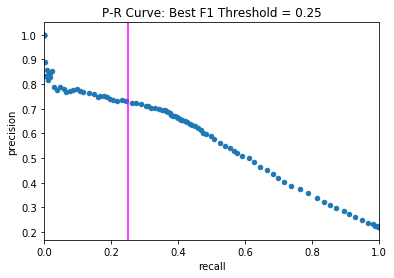

In [12]:
title_ = 'P-R Curve: Best F1 Threshold = ' + str(gbm_cut)
ax = prauc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(gbm_cut, color='magenta')

#### Function to calculate confusion matrices
Once a cutoff has been established, a confusion matrix can be created. A confusion matrix is basic model assessment technique that shows how often a model is correct and incorrect, and how it is incorrect, e.g. type I (false positive) and type II (false negative) errors. 

In [13]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, 
        can be sliced by a variable and level.
 
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, 
            default None.
        level: Value of by variable to slice frame before creating confusion 
               matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & 
                                        (frame_[dname] == lev_j)].shape[0]
            # i,j vs. j,i - nasty little bug updated 8/30/19
    
    return cm_frame
    
cm = get_confusion_matrix(test_yhat, y, yhat, cutoff=gbm_cut)
cm.style.set_caption('Confusion Matrix')

,actual: 1,actual: 0
predicted: 1,1218,1208
predicted: 0,768,5860


The confusion matrix shows that the GBM model is more accurate than not because the true positive and true negative cells contain the largest values by far. But the GBM model seems to make a large number of type I errors, or false positive predictions. False positives are a known disparity issue, because for complex reasons, many credit scoring and other models tend to overestimate the likelihood of non-reference groups - typically not white males - to default. The large amount of false positives could indicate that a lot of deserving people will not receive loans that they could actually pay back according to this model. This is a potential pathology that should definitely be investigated further.

## 5. Basic Residual Analysis

#### Score test data and calculate logloss residuals
Because special functionality in XGBoost to find Shapley contributions to logloss will be used later, logloss residuals are used in several places in this notebook.

In [14]:
# shortcut name
resid = 'r_DEFAULT_NEXT_MONTH' 

# calculate logloss residuals
test_yhat[resid] = -test_yhat[y]*np.log(test_yhat[yhat]) -\
                       (1 - test_yhat[y])*np.log(1 - test_yhat[yhat])   
    
# check that logloss is calculated correctly
# should match eval-logloss above
print('Mean logloss residual: %.6f' % test_yhat[resid].mean())

Mean logloss residual: 0.426544


#### Plot global logloss residuals
Plotting residuals is almost always a good idea. You can see all of your model's predictions in two-dimensions!

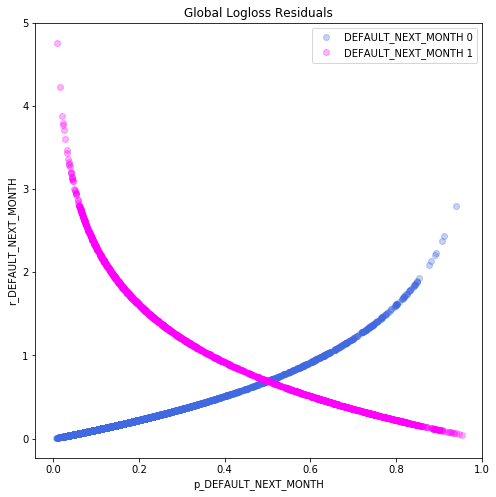

In [15]:
 # initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

# plot groups with appropriate color
color_list = ['royalblue', 'magenta'] 
c_idx = 0
groups = test_yhat.groupby(y) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.p_DEFAULT_NEXT_MONTH, group.r_DEFAULT_NEXT_MONTH, 
             label=' '.join([y, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1
    
# annotate plot
_ = plt.xlabel(yhat)
_ = plt.ylabel(resid)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

Some high-magnitude outlying residuals are visible. Who are these customers? Why is the model so wrong about them? And are they somehow exerting undue influence on other predictions? The model could be retrained without these individuals and retested as a potentially remediation strategy. From a security standpoint it can be interesting to examine insider attacks and false negatives. These are people who where issued a loan, but did not pay it back. Are any of these employees, contractors, consultants, or their associates? Could they have poisoned the model's training data to receive the loan? Could they have changed the model's production scoring code to receive the loan?

#### Examine high logloss individuals

In [16]:
# sort by residual and display
test_yhat_sorted = test_yhat.\
    sort_values(by=resid, ascending=False).\
    reset_index(drop=True)
    
test_yhat_sorted.head() # large positive residuals

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
0,983,500000,1,1,2,36,-2,-2,-2,-2,-2,-2,45106,81264,18122,27229,21462,27911,81690,18225,27365,21570,28050,17397,1,0.008568,4.759735
1,25772,350000,2,1,1,33,0,-1,-1,-1,-1,-1,82964,68532,17926,17966,30741,31088,68940,18018,18058,30897,31244,88461,1,0.014528,4.231679
2,2561,310000,2,1,2,32,-2,-2,-2,-2,-2,-2,20138,8267,65993,8543,1695,750,8267,66008,8543,1695,750,7350,1,0.020749,3.875251
3,11571,200000,1,2,2,30,-2,-2,-2,-2,-2,-2,48492,49934,24753,123439,132269,129224,20294,24891,125171,17816,26269,4349,1,0.022548,3.792118
4,16209,360000,2,1,1,35,-2,-1,0,-1,-1,-1,94657,34529,106276,73331,7759,31840,45000,100000,73427,7759,31840,12577,1,0.023161,3.765297


High positive residuals seem to be caused by people with excellent payment behavior who suddenly default. 

#### Examine low logloss residuals

In [17]:
test_yhat_sorted.tail()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
9049,14136,500000,1,1,2,43,-1,-1,-1,-1,-1,-1,37575,105652,51072,77094,77669,42059,107243,52090,78372,78949,42985,62793,0,0.009764,0.009811
9050,27603,400000,2,1,2,29,-2,-2,-2,-2,-2,-2,7622,38849,13586,19502,3809,4512,39097,13653,19617,3930,7021,24987,0,0.009571,0.009617
9051,28744,440000,2,2,2,29,-1,-1,-1,-1,0,0,23147,88848,42045,400321,229680,265404,70554,45213,400972,5456,100267,7530,0,0.008327,0.008362
9052,3775,500000,2,1,2,32,-1,-1,-1,-1,-1,-1,103880,39356,301441,37945,104491,35234,39560,302961,38139,104673,35387,177258,0,0.007642,0.007671
9053,23477,480000,2,1,2,32,-2,-2,-2,-2,-2,-2,11872,38933,23479,52177,54005,53853,40000,23479,52209,54005,54500,42321,0,0.005813,0.005830


The model seems to have the easiest time making correct decisions about customers with good payment behavior who sustain that behavior.

#### Residuals plotted by important variables: `PAY_0`
To take residual analysis farther, try plotting residuals by values of important variables or across bins of important variables. 

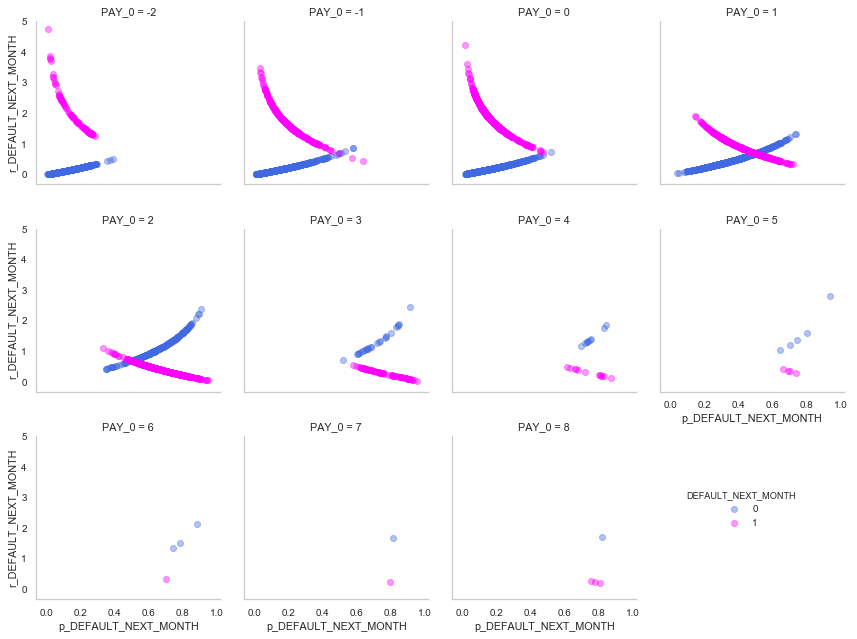

In [18]:
# some seaborn configs
sns.set(font_scale=0.9)                                         # legible font size
sns.set_style('whitegrid', {'axes.grid': False})                # white background, no grid in plots
sns.set_palette(sns.color_palette(["#4169e1", "#ff00ff"]))      # consistent colors

# facet grid of residuals by PAY_0 
sorted_ = test_yhat.sort_values(by='PAY_0')                     # sort for better layout of by-groups
g = sns.FacetGrid(sorted_, col='PAY_0', hue=y, col_wrap=4)      # init grid
_ = g.map(plt.scatter, yhat, resid, alpha=0.4)                  # plot points
_ = g.add_legend(bbox_to_anchor=(0.82, 0.2))                    # legend

Here, a problem with the model is visible. For people whose most recent repayment status, i.e. `PAY_0` value, is good, `PAY_0 <= 1`, the model appears to struggle to predict default. When the model predicts this type of customer will not default, and they do, this results in large residuals. For people with late most recent payments, `PAY_0 > 1`, the model appears to struggle to predict on-time payment. When the model predicts people with late most recent payments will default, and then they don't, this also causes large residuals. *A mechanism for error* has been identified: over-emphasis of a feature: `PAY_0 > 2`. These problems could be become worse if market conditions change, such as in a recession, where more people with good payment behavior could default suddenly. 

#### Residuals plotted by important variables: `SEX`
While not a frontline fairness tool, it can be interesting to examine residuals across demographic variables to get a sense of whether the model's errors are different across these groups. 

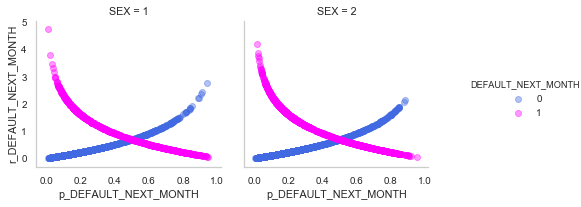

In [19]:
# facet grid of residuals by SEX
sorted_ = test_yhat.sort_values(by='SEX')                # sort for better layout of by-groups
g = sns.FacetGrid(sorted_, col='SEX', hue=y, col_wrap=4) # init grid 
_ = g.map(plt.scatter, yhat, resid, alpha=0.4)           # plot points
_ = g.add_legend(bbox_to_anchor=(0.6, 0.5))              # legend

The residual profile is not dramatically different for men (`SEX = 1`) and women (`SEX = 2`). The largest magnitude residuals appear for men and for false positive predictions.

## 6. Disparate Error Analysis
The analysis in this section applies simple but numerous metrics to the accuracy and error of the model across the values of important or demographic variables to discover any potential blindspots in the model's predictions.

#### Represent error metrics as dictionary for use later
These are the metrics that will be examined across important and demographic variables. These metrics are based on the confusion matrix, but any other metrics would likely be useful as well.

In [20]:
metric_dict = {

#### overall performance
'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
#'Adverse Impact': '(tp + fp) / (tp + tn + fp + fn)', # how often the model predicted default for each group   
'Accuracy':       '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group

#### predicting default will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

#### predicting default won't happen
# (correctly)
'Specificity':              'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

#### analyzing errors - type II
# costly ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}    

#### Small utility functions used to calculate and display different types of errors 
A number of small, tightly coupled utility functions are used to calculate and display the error metrics across the values of important or demographic variables.

In [21]:
# small utility functions
# all tightly coupled to global names and data structures !!

def cm_exp_parser(expression):
    
    """ Translates abbreviated metric expressions from metric_dict 
        into executable Python statements.
    
    Arg: 
        expression: Error metric expression from metric_dict.
        
    Returns:
        Python statements based on predefined metrics in metric_dict.
        
    """
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', '(cm_dict[level].iat[0, 0] + eps)')\
                           .replace('fp', '(cm_dict[level].iat[0, 1] + eps)')\
                           .replace('fn', '(cm_dict[level].iat[1, 0] + eps)')\
                           .replace('tn', '(cm_dict[level].iat[1, 1] + eps)')

    return expression

################################################################################

def get_cm_dict(name, cutoff):

    """ Loops through levels of named variable and calculates confusion 
        matrices per level; uses dynamically generated entities to reduce 
        code duplication. 
    
    Args:
        name: Name of variable for which to calculate confusion matrices.
        cutoff: Cutoff threshold for confusion matrices. 
    
    Returns:
        Dictionary of confusion matrices. 
    
    """

    levels = sorted(list(test_yhat[name].unique())) # get levels
    cm_dict = {} # init dict to store confusion matrices per level
    for level in levels: 
    
        # dynamically name confusion matrices by level
        # coerce to proper python names
        cm_name = '_' + str(level).replace('-', 'm') + '_cm' 
    
        # dynamically calculate confusion matrices by level
        code = cm_name + ''' = get_confusion_matrix(test_yhat,                              
                          y, 
                          yhat, 
                          by=name, 
                          level=level, 
                          cutoff=cutoff)'''
        exec(code)
        exec('cm_dict[level] = ' + cm_name) # store in dict
        
    return cm_dict

################################################################################

def get_metrics_frame(name): 

    """ Loops through levels of named variable and metrics to calculate each 
        error metric per each level of the variable; uses dynamically generated 
        entities to reduce code duplication.
    
    Arg:
        name: Name of variable for which to calculate error metrics.
    
    Return:
        Pandas DataFrame of error metrics.
        
    """
    
    levels = sorted(list(test_yhat[name].unique())) # get levels
    metrics_frame = pd.DataFrame(index=levels) # init Pandas frame for metrics
    eps = 1e-20 # for safe numerical operations

    # nested loop through:
    # - levels
    # - metrics 
    for level in levels:
        for metric in metric_dict.keys():
              
            # parse metric expressions into executable pandas statements
            expression = cm_exp_parser(metric_dict[metric])
        
            # dynamically evaluate metrics to avoid code duplication
            metrics_frame.loc[level, metric] = eval(expression)  

    # display results
    return metrics_frame


#### Display all error metrics across levels of `PAY_0`

In [22]:
name = 'PAY_0'
cm_dict = get_cm_dict(name, gbm_cut) # get dict of confusion matrices

# print formatted error metrics frame: precision, title, colors
PAY_0_metrics = get_metrics_frame(name)
PAY_0_metrics['PAY_0'] = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_0_metrics.set_index('PAY_0', inplace=True)
PAY_0_metrics.round(3).\
    style.set_caption('Error Metrics for ' + name).\
    background_gradient(cmap=sns.diverging_palette(-20, 260, n=7, as_cmap=True), 
                        axis=1)

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
PAY_0,,,,,,,,,,
-2,0.124,0.851,0.188,0.322,0.944,0.892,0.056,0.678,0.812,0.108
-1,0.168,0.799,0.267,0.366,0.907,0.86,0.093,0.634,0.733,0.14
0,0.121,0.865,0.143,0.357,0.965,0.891,0.035,0.643,0.857,0.109
1,0.325,0.459,0.94,0.37,0.227,0.887,0.773,0.63,0.06,0.113
2,0.709,0.709,1,0.709,0,0.5,1,0.291,0,0.5
3,0.748,0.748,1,0.748,0,0.5,1,0.252,0,0.5
4,0.571,0.571,1,0.571,0,0.5,1,0.429,0,0.5
5,0.444,0.444,1,0.444,0,0.5,1,0.556,0,0.5
6,0.25,0.25,1,0.25,0,0.5,1,0.75,0,0.5


As identified by basic residual analysis, it can be seen here that the model behaves extremely differently for customers with `PAY_0 <= 1` and `PAY_0 > 1`, likely due to sparsity of data in the `PAY_0 > 1` range. Again, this may be acceptable behavior today, but what if market conditions drift and these types of behaviors become more common and model mistakes become more costly in the future?

#### Display all error metrics across levels of `SEX`

In [23]:
name = 'SEX'
cm_dict = get_cm_dict(name, gbm_cut) # get dict of confusion matrices

# print formatted error metrics frame: precision, title, colors
sex_metrics = get_metrics_frame(name)
sex_metrics['SEX'] = ['Male', 'Female']
sex_metrics.set_index('SEX', inplace=True)
sex_metrics.round(3).\
    style.set_caption('Error Metrics for ' + name).\
    background_gradient(cmap=sns.diverging_palette(-20, 260, n=7, as_cmap=True), 
                        axis=1)

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
SEX,,,,,,,,,,
Male,0.235,0.771,0.652,0.509,0.807,0.883,0.193,0.491,0.348,0.117
Female,0.209,0.789,0.584,0.497,0.843,0.885,0.157,0.503,0.416,0.115


Unlike `PAY_0`, different types of error and accuracy measures appear fairly aligned for men and women.

## 7. Benchmark Models

Benchmark models are an excellent model debugging tool. They can be used at training time to understand how a new model differs from an established, trusted model. They can also be used at scoring time to understand if a newer or more complex model is giving different predictions from a previously deployed trusted model or simpler model. If a prediction from a new model is too different from a prediction from a trusted model, this could be indicative of potential accuracy, fairness, or security problems.

#### Function for simple grid search across alpha for penalized GLM
Instead of using a pre-existing model, a stable penalized GLM will be used as a benchmark in this notebook.

In [24]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    
    # define search criteria
    # i.e. over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts} 

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="binomial",
            lambda_search=True,
            seed=SEED),
        hyper_params=hyper_parameters)
    
    # run grid search
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # select best model from grid search
    return grid.get_grid()[0]

best_glm = glm_grid(X, y, h2o.H2OFrame(train), h2o.H2OFrame(test))
print('Best penalized GLM mean logloss residual: %.6f' % 
      best_glm.logloss(valid=True))
glm_cut = best_glm.F1(valid=True)[0][0] # get GLM cutoff to create decisions
print('At threshold: %.6f' % glm_cut)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
Best penalized GLM mean logloss residual: 0.461254
At threshold: 0.300562


#### Find rows where GLM benchmark model is right, but GBM is wrong
One interesting place to start comparing a more complex model to a simpler model is when the simple model is right and the complex model is wrong.

In [25]:
# copy test data
test_yhat2 = test_yhat.copy(deep=True)

# create columns for gbm and glm preds
test_yhat2.rename(columns={yhat: 'p_gbm_DEFAULT_NEXT_MONTH'}, inplace=True)
test_yhat2['p_glm_DEFAULT_NEXT_MONTH'] = best_glm.\
    predict(h2o.H2OFrame(test))['p1'].\
    as_data_frame()

# create columns for gbm and glm decisions (i.e. apply cutoff)
test_yhat2['gbm_DECISION'] = 0
test_yhat2.loc[test_yhat2['p_gbm_DEFAULT_NEXT_MONTH'] > gbm_cut,
               'gbm_DECISION'] = 1
test_yhat2['glm_DECISION'] = 0
test_yhat2.loc[test_yhat2['p_glm_DEFAULT_NEXT_MONTH'] > glm_cut,
               'glm_DECISION'] = 1

# create columns for gbm and glm wrong decisions
test_yhat2['gbm_WRONG'] = 0
test_yhat2.loc[test_yhat2[y] != test_yhat2['gbm_DECISION'], 'gbm_WRONG'] = 1
test_yhat2['glm_WRONG'] = 0
test_yhat2.loc[test_yhat2[y] != test_yhat2['glm_DECISION'], 'glm_WRONG'] = 1

# create a subset of preds where gbm is wrong, but glm is right
gbm_wrong = test_yhat2.loc[(test_yhat2['gbm_WRONG'] == 1) & 
                           (test_yhat2['glm_WRONG'] == 0)]

gbm_wrong[X + [y, 'p_glm_DEFAULT_NEXT_MONTH', 'p_gbm_DEFAULT_NEXT_MONTH']].head()

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_glm_DEFAULT_NEXT_MONTH,p_gbm_DEFAULT_NEXT_MONTH
7,360000,2,1,1,49,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.278097,0.338736
8,180000,2,1,2,29,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.238463,0.297329
22,200000,2,1,2,34,-1,3,2,2,2,2,1587,1098,782,1166,700,1414,0,0,700,0,1200,0,0,0.227727,0.508433
25,130000,2,3,2,29,1,-2,-2,-1,2,-1,-190,-9850,-9850,10311,10161,7319,0,0,20161,0,7319,13899,0,0.240743,0.402143
27,290000,2,1,2,37,1,-2,-1,-1,-1,-1,0,0,3155,0,2359,0,0,3155,0,2359,0,0,0,0.261741,0.253493


For the subset of customers where the more complex GBM model is wrong and the GLM model is right, the predictions of two models appear to be inversely correlated. 

#### Plot rows where GLM benchmark model is right, but GBM is wrong

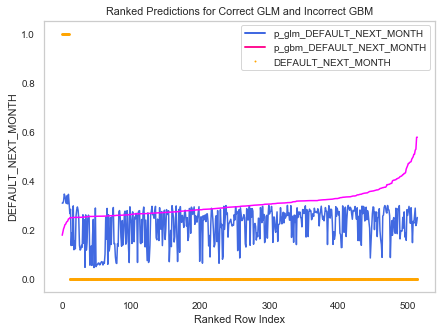

In [26]:
# custom legend
custom = [Line2D([0], [0], color='royalblue', lw=2),
          Line2D([0], [0], color='deeppink', lw=2),
          Line2D([0], [0], marker='o', color='w',
          markerfacecolor='orange', markersize=3)]

# init plot
fig, ax = plt.subplots(figsize=(7, 5)) 

# plot sorted actuals
# double index reset orders index by sort variable and
# brings index into frame for plotting
_ = gbm_wrong[[y,'p_gbm_DEFAULT_NEXT_MONTH']].\
            sort_values(by='p_gbm_DEFAULT_NEXT_MONTH').\
            reset_index(drop=True).\
            reset_index().\
            plot(kind='scatter', x='index', y=y, color='orange', s=3, ax=ax, 
                 legend=False)

# plot sorted gbm and glm preds 
_ = gbm_wrong[['p_glm_DEFAULT_NEXT_MONTH', 'p_gbm_DEFAULT_NEXT_MONTH']].\
            sort_values(by='p_gbm_DEFAULT_NEXT_MONTH').\
            reset_index(drop=True).\
            plot(ax=ax, legend=False, 
                 title='Ranked Predictions for Correct GLM and Incorrect GBM')

# annotate plot
_ = ax.legend(custom, ['p_glm_DEFAULT_NEXT_MONTH', 'p_gbm_DEFAULT_NEXT_MONTH', 
                       y])
_ = ax.set_xlabel('Ranked Row Index')

For a range of probabilities between ~0.2 and ~0.6 there exists a group of customers where a GLM model gives more correct predictions than the more complex GBM model. In the plot above, the yellow points represent the known target labels, the pink line is the sorted GBM model predictions, and the blue line is the GLM predictions for the same customers and target labels. For this group of people the GLM is obviously able to better represent some attribute of the customer's demographics or behaviors. Can the differences between this group of people and the rest of the customers be identified and leveraged to make better predictions?

#### Descriptive statistics for rows where GLM benchmark model is right, but GBM is wrong

In [27]:
gbm_wrong.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_gbm_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH,p_glm_DEFAULT_NEXT_MONTH,gbm_DECISION,glm_DECISION,gbm_WRONG,glm_WRONG
count,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.0,515.0
mean,14018.611650,165067.961165,1.551456,1.856311,1.487379,36.322330,0.056311,-0.710680,-0.483495,-0.522330,-0.613592,-0.687379,18646.407767,18464.543689,17676.000000,17218.322330,17326.433010,16517.881553,1791.077670,1616.370874,1589.757282,1884.291262,2497.504854,2869.493204,0.021359,0.306780,0.396920,0.223934,0.978641,0.021359,1.0,0.0
std,8481.966013,120526.347454,0.497829,0.854568,0.537808,8.569752,1.026276,1.422369,1.595598,1.600397,1.512660,1.484464,56196.427225,54365.519342,53128.180257,51710.987463,51304.597844,48028.545492,4780.215103,7529.071927,6147.515044,10900.914415,12121.558040,15071.003400,0.144719,0.054682,0.186110,0.068448,0.144719,0.144719,0.0,0.0
min,19.000000,10000.000000,1.000000,1.000000,0.000000,22.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-9802.000000,-9850.000000,-9850.000000,-4894.000000,-37594.000000,-21295.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.178708,0.287739,0.047264,0.000000,0.000000,1.0,0.0
25%,6981.500000,50000.000000,1.000000,1.000000,1.000000,30.000000,-1.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.268311,0.314540,0.172821,1.000000,0.000000,1.0,0.0
50%,13390.000000,160000.000000,2.000000,2.000000,1.000000,35.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,317.000000,390.000000,326.000000,316.000000,291.000000,326.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.295786,0.354366,0.249047,1.000000,0.000000,1.0,0.0
75%,21225.500000,230000.000000,2.000000,2.000000,2.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6532.500000,8022.000000,8440.000000,8267.000000,8447.500000,8503.000000,1607.500000,1169.500000,769.000000,832.000000,1000.000000,1000.000000,0.000000,0.324802,0.397921,0.276170,1.000000,0.000000,1.0,0.0
max,29956.000000,710000.000000,2.000000,6.000000,3.000000,63.000000,2.000000,3.000000,3.000000,7.000000,6.000000,5.000000,455293.000000,441048.000000,433541.000000,425538.000000,419080.000000,381132.000000,59068.000000,97225.000000,80677.000000,180000.000000,202317.000000,166196.000000,1.000000,0.578387,1.722003,0.346547,1.000000,1.000000,1.0,0.0


If this group of people can be isolated, either by descriptive statistics, or by more sophisticated means, the training process could be adapted to fix these errors or another model could be used at scoring time to create more accurate predictions. Even if a group cannot be isolated, the two different model predictions could potentially be blended in this range of predicted probabilities. 

## 8. Explanation of Residuals
A novel and very interesting application of post-hoc explanation techniques is in-depth investigation of model residuals. Below post-hoc explanation of predictions and residuals are used to further debug model predictions.

### 8.1 Shapley Values for Residuals and Predictions

#### Calculate Shapley values for logloss for each row
A fairly recent addition to the `shap` package is the ability to calculate Shapley contributions to logloss. From this potentially very time-consuming calculation, an accurate estimate of each variable's contribution to the model's error for each row can be known. This notebook is shipped with pre-calculated values, but you can calculate them too. It might take a few hours though.

In [28]:
# init explainer object for access to explainer.expected_value() function below
# expected value is a function for loss, not a constant
explainer = shap.TreeExplainer(xgb_model, test_yhat[X], 
                               feature_dependence='independent',  # necessary for logloss 
                               model_output='logloss')            # necessary for logloss

# load if pre-calculated
if os.path.isfile('shap_error_values.csv'):

    shap_error_values = np.loadtxt('shap_error_values.csv', delimiter=',') # load
    print('Pre-calculated Shapley values loaded from disk.') # print confirmation
    
# else, calculate
else: 

    xgb_model.set_attr(objective='binary:logistic')
    shap_error_values = explainer.shap_values(test_yhat[X], y=test_yhat[y]) # long step (hours!)
    np.savetxt('shap_error_values.csv', shap_error_values, delimiter=',') # save for immediate reuse later

Pre-calculated Shapley values loaded from disk.


#### Calculate Shapley values for prediction for each row

In [29]:
shap_values = xgb_model.predict(dtest, pred_contribs=True) 

#### Plot Shapley value summary for global importance measure in prediction and residuals

Once the local Shapley contributions to the predictions and logloss are known, they can be aggregated by their mean absolute value to create global importance metrics. 

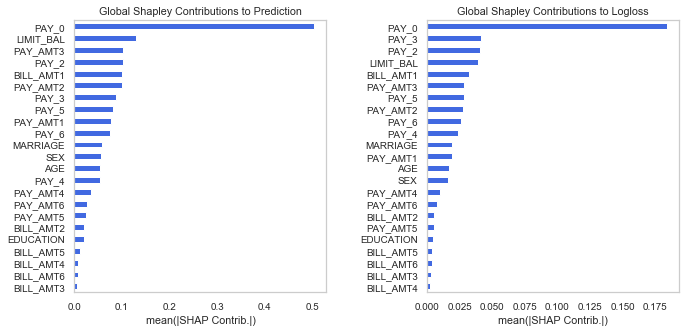

In [30]:
# init two pane plot
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=False, figsize=(7, 5))
plt.subplots_adjust(left=0.0, right=1.2, wspace=0.4)

# plot global abs mean Shapley contribs to predictions
global_shap_values_pd = pd.DataFrame(np.abs(shap_values[:, :-1]).mean(axis=0),
                                     index=X, columns=['Pred. Contribs.'])
_ = global_shap_values_pd.sort_values(by='Pred. Contribs.').\
        plot(kind='barh', ax=ax0, legend=False, color='royalblue',
             title='Global Shapley Contributions to Prediction')
_ = ax0.set_xlabel('mean(|SHAP Contrib.|)')

# plot global abs mean Shapley contribs to logloss
global_shap_error_values_pd = pd.DataFrame(np.abs(shap_error_values).mean(axis=0), 
                                           index=X, columns=['Loss Contribs.'])
_ = global_shap_error_values_pd.sort_values(by='Loss Contribs.').\
        plot(kind='barh', ax=ax1, legend=False, color='royalblue',
             title='Global Shapley Contributions to Logloss')
_ = ax1.set_xlabel('mean(|SHAP Contrib.|)')

Some features are more important to the logloss than to the predictions! These include `PAY_3`, `PAY_2`, and `BILL_AMT1`. The model could potentially be retrained without these features.

#### Mean Shapley contributions of high and low residual customers
Shapley contributions to predictions are reliably available at scoring time. It may be possible to understand what Shapley contributions look like for correct model decisions and for incorrect model decisions and take remediation steps in real-time before issuing model predictions.

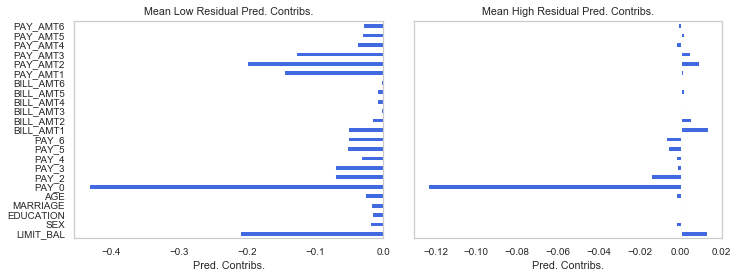

In [31]:
# init two pane plot
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True)
plt.subplots_adjust(left=0.0, right=1.5, wspace=0.1)

# convert shap_values into Pandas DataFrame 
# merge residuals onto this frame
local_shap_values_pd = pd.DataFrame(shap_values[:, :-1], columns=X)
local_shap_values_pd[resid] = test_yhat[resid]

# plot mean shap values of 100 lowest residual customers 
_ = local_shap_values_pd.sort_values(by=resid).\
        reset_index(drop=True).\
        iloc[:1000, :-1].mean(axis=0).\
        plot(kind='barh', color='royalblue', ax=ax0, 
             title='Mean Low Residual Pred. Contribs.')
_ = ax0.set_xlabel('Pred. Contribs.')

# plot mean shap values of 100 highest residual customers
_ = local_shap_values_pd.sort_values(by=resid).\
        reset_index(drop=True).\
        iloc[-1000:, :-1].mean(axis=0).\
        plot(kind='barh', color='royalblue', ax=ax1,
            title='Mean High Residual Pred. Contribs.')
_ = ax1.set_xlabel('Pred. Contribs.')

Here large differences in average Shapley values are visible between low and high residual model predictions. On average, correct model decisions have negative Shapley values, while incorrect decisions have small magnitude Shapley values. If, when issuing a prediction, the Shapley values are low magnitude, the row could be diverted to another model, say the linear benchmark model, or sent for human processing. Input data, particularly features with large global or local Shapley contributions to loss, could also be corrupted with missing values in hopes of attaining a better model prediction. 

#### Residuals vs. local Shapley prediction values in 2-D
Shapley contributions to predictions can also be plotted against residual values, in hopes of understanding if certain model behaviors lead to higher errors.

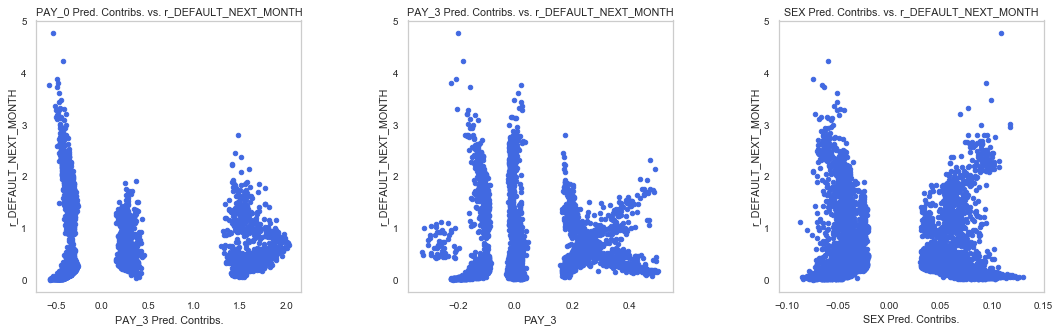

In [32]:
# init three pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=False, figsize=(7, 5))
plt.subplots_adjust(left=0.0, right=2, wspace=0.4)

# plot shap vs. important variable PAY_0
_ = local_shap_values_pd.plot(kind='scatter', y=resid, x='PAY_0', color='royalblue',
                        title='PAY_0 Pred. Contribs. vs. ' + resid, ax=ax0)
_ = ax0.set_xlabel('PAY_0 Pred. Contribs.')

# plot shap vs. important variable PAY_3
_ = local_shap_values_pd.plot(kind='scatter', y=resid, x='PAY_3', color='royalblue',
                        title='PAY_3 Pred. Contribs. vs. ' + resid, ax=ax1)
_ = ax0.set_xlabel('PAY_3 Pred. Contribs.')

# plot shap vs. demographic variable SEX
_ = local_shap_values_pd.plot(kind='scatter', y=resid, x='SEX', color='royalblue',
                        title='SEX Pred. Contribs. vs. ' + resid, ax=ax2)
_ = ax2.set_xlabel('SEX Pred. Contribs.')

Here it appears there are no single Shapley contributions that can be associated with only high residuals. Every extremely high residual value also has low residual values for the same Shapley value. However, it can be seen that some Shapley values are only associated with low residuals, for instance `0 < PAY_0` Contribs. `< 0.5` or `PAY_3` Contribs. `< -0.2`. If trying to detect scoring problems in real-time, Shapley values in these ranges for these features could indicate that these predictions are likely to be correct. Also, in terms of local feature importance, the model is not treating `SEX` very differently -- a good sign from a fairness perspective but not a definitive test. From a security perspective, high residuals above low residuals are potentially interesting. These are individuals the model usually gets right, but for some reason they did not in this case. That could indicate manipulation of the training data or model scoring logic in rare cases.

#### Residuals vs. local Shapley prediction values in 3-D
If relationships between Shapley contributions and dependably high residuals cannot be found in two-dimensions, they may be visible in three dimensions when two features interact.

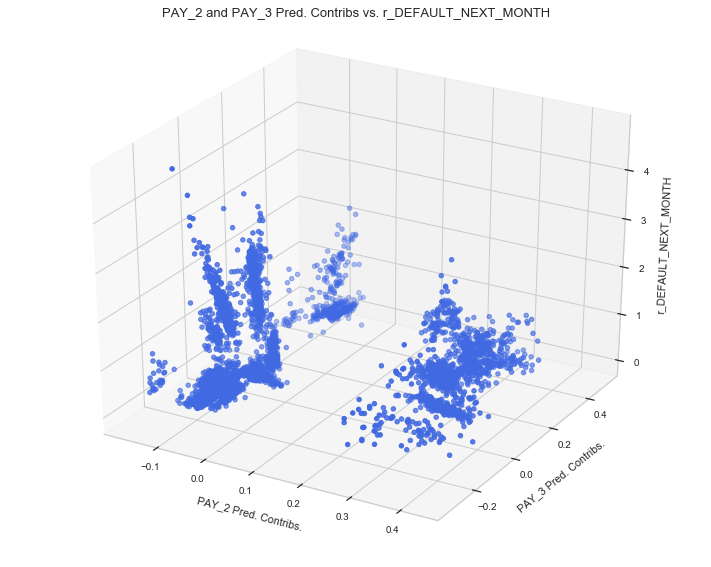

In [33]:
# init 3-D plot
fig, ax = plt.subplots(figsize=(10, 8))
ax = plt.axes(projection='3d')

# z-axis: residuals values
_z = local_shap_values_pd[resid].values
ax.set_zlabel(resid)

# x-axis: PAY_2 values
_x = local_shap_values_pd['PAY_2'].values
ax.set_xlabel('\nPAY_2 Pred. Contribs.')

# y-axis: PAY_3 values
_y = local_shap_values_pd['PAY_3'].values
ax.set_ylabel('\nPAY_3 Pred. Contribs.')

# plot and annotate
_ = ax.scatter3D(_x, _y, _z, color='royalblue')
fig.suptitle('PAY_2 and PAY_3 Pred. Contribs vs. ' + resid) 
plt.tight_layout()

Here two features that are globally more important to logloss than to the model predictions are plotted against model residuals.  Like directly above, these plots can also be used to find potentially interesting regions of purely high or low residuals, differences in model behavior across demographic segments, or strange patterns indicating possible manipulation of data or model logic. Cluster profiles of this space seem particularly interesting.

#### Shapley contributions to logloss for a specific individual
Much like individual Shapley contributions to predictions, individual Shapley contributions to logloss residuals show exactly how much a variable contributes to the logloss for any individual in the training data.

In [34]:
# select highest residual individual
row_id = test_yhat_sorted.loc[0, 'ID']
row = test_yhat[test_yhat['ID'] == row_id]

# match to their shap loss contribs
# create Pandas DataFrame
# display
s_df = pd.DataFrame(shap_error_values[row.index[0], :].reshape(23, 1), 
                    columns=['Loss Contribs.'], index=X)
s_df.sort_values(by='Loss Contribs.', inplace=True, ascending=False)
s_df

,Loss Contribs.
PAY_AMT1,0.611533
LIMIT_BAL,0.403705
PAY_AMT2,0.352150
PAY_0,0.311651
PAY_3,0.272713
PAY_AMT3,0.184478
PAY_6,0.147152
PAY_2,0.128540
BILL_AMT1,0.123718
MARRIAGE,0.100163


For this high-residual individual, `PAY_AMT1`, `LIMIT_BAL`, and `PAY_AMT2` have the largest positive impact on the model error.

#### Check Shapley values for local accuracy
Just to make sure Shapley is locally accurate, it can be shown that the Shapley contributions sum directly to the logloss for this individual.

In [35]:
# should match residual value for row ... very close
print('Total Shapley contributions to logloss: %.6f' % 
        (s_df['Loss Contribs.'].sum() + explainer.expected_value(row[y].values[0])))

Total Shapley contributions to logloss: 4.830307


#### Plot Shapley contributions to logloss for a specific individual

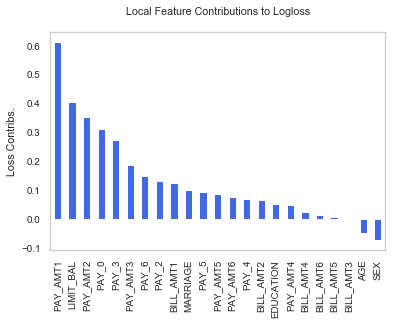

In [36]:
# plot barchart of top five loss contribs
ax = s_df.plot(kind='bar', 
                  title='Local Feature Contributions to Logloss\n',
                  color='royalblue',
                  legend=False)

# annotate
_ = ax.set_ylabel('Loss Contribs.')

#### Combine Shapley values with row values to explain logloss
Just like reason codes, or simple written explanations, can be generated for each model prediction. Reason codes can also be generated for logloss for each model prediction by combining the ranking provided by Shapley values and the individual row values. 

In [37]:
row # helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
300,983,500000,1,1,2,36,-2,-2,-2,-2,-2,-2,45106,81264,18122,27229,21462,27911,81690,18225,27365,21570,28050,17397,1,0.008568,4.759735


For this individual the top five characteristics contributing to the logloss residual are:


* Most recent payment is NT dollar 81,690 (high)
* Credit limit is NT dollar 500,000 (high)
* Second most recent payment is NT dollar 18,225 (high)
* Most recent repayment status is very good
* Third most recent repayment status is very good

All of the variables contributing to high logloss for this individual have values that would be considered positive attributes: large payments, high credit limit, and good repayment statuses. Essentially the model is surprised this person defaulted. This could mean that the model is too reliant on repayment statuses, as was seen by plotting residuals against `PAY_0` values, or it may also indicate the model requires more information to make good decisions, likely in the form of additional input variables.

In general, when examining local contributions to logloss, one might consider whether local contributions to predictions and errors are parsimonious or might indicate tampering with the data or model scoring logic or whether protected variables are weighing heavily in a model decision. Also, and although tedious and time-consuming today, one could use sensitivity analysis to understand how changing model inputs could affect model outcomes for different individuals.

### 8.2  Explain LogLoss Residuals with Decision Trees
A time-tested method of determining if a model is fundamentally biased, either missing data or too simple in form, is to determine whether strong patterns exist in the model residuals. One way to determine if these patterns exist is to model the residuals themselves. When the model used is a decision tree or rule-based model, this opens up the possibility of automatically generating rules that indicate when or why a model might be wrong. 

#### Small utility functions used to generate decision trees
This set of small functions is used to train decision trees on logloss residuals and display those trees.

In [38]:
# small utility functions
# all tightly coupled to global names and data structures !!

def train_cv_dt(model_id, frame):
                             
    """ Utility function to train decision trees.
    
    Args:
        model_id: h2o model identifier. 
        frame: Pandas DataFrame containing X and yhat on which to train 
               the decision trees.
               
    Returns:
        Path to saved model MOJO (Java scoring artifact), 
        model as h2o model object.
    
    """
        
    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                    sample_rate=1,     # use all rows in that tree
                                    mtries=-2,         # use all columns in that tree's split search
                                    max_depth=4,       # shallow trees are easier to understand
                                    seed=SEED,         # set random seed for reproducibility
                                    nfolds=3,          # cross-validation for stability and ...
                                                       # only way to get metrics for 1 tree in h2o
                                    model_id=model_id) # gives MOJO artifact a recognizable name

    # train single tree model
    tree.train(x=X, y=resid, training_frame=h2o.H2OFrame(frame))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)
    
    return mojo_path, tree

################################################################################

# 
def get_gv(title, model_id, mojo_path):

    """ Utility function to generate graphviz dot file from h2o MOJO using 
        a subprocess.
    
    Args:
        title: Title for displayed decision tree.
        model_id: h2o model identifier. 
        mojo_path: Path to saved model MOJO (Java scoring artifact); 
                   generated by train_cv_dt function above. 
                   
    """
    
    # locate h2o jar
    hs = H2OLocalServer()
    h2o_jar_path = hs._find_jar()
    print('Discovered H2O jar path:\n', h2o_jar_path)

    # construct command line call to generate graphviz version of 
    # tree, see for more information: 
    # http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
    gv_file_name = model_id + '.gv'
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                  + mojo_path + ' -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(gv_file_name)
    if title is not None:
        gv_args = gv_args + ['--title', title]
    
    # call constructed command
    print()
    print('Calling external process ...')
    print(' '.join(gv_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(gv_args, shell=True)
    _ = subprocess.call(gv_args)

################################################################################

def get_png(model_id):

    """ Utility function to generate PNGs from .dots using a subprocess.
    
    Arg:
        model_id: h2o model identifier. 
    
    """
    
    gv_file_name = model_id + '.gv'
    
    # construct call to generate PNG from 
    # graphviz representation of the tree
    png_file_name = model_id + '.png'
    png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
    png_args = png_args.split()

    # call 
    print('Calling external process ...')
    print(' '.join(png_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(png_args, shell=True)    
    _ = subprocess.call(png_args)
    

#### Train decision trees

In [39]:
# train trees
mojo_path0, tree0 = train_cv_dt('tree0', test_yhat[test_yhat[y] == 0])                                     
mojo_path1, tree1 = train_cv_dt('tree1', test_yhat[test_yhat[y] == 1])  

# shutdown h2o
h2o.cluster().shutdown()

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /Users/ngill/Desktop/interpretable-ml/python/jupyter-notebooks/credit/binomial/tree0.zip
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /Users/ngill/Desktop/interpretable-ml/python/jupyter-notebooks/credit/binomial/tree1.zip
H2O session _sid_ad73 closed.


#### Display error measures to ensure trustworthiness of models: `DEFAULT_NEXT_MONTH = 0` logloss residuals

In [40]:
# cv metrics for y = 0 tree
tree0.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.055960342,0.0025096652,0.053293385,0.058275614,0.056312032
1,mean_residual_deviance,0.0070040254,5.1976327E-4,0.0067012534,0.0076041883,0.006706634
2,mse,0.0070040254,5.1976327E-4,0.0067012534,0.0076041883,0.006706634
3,r2,0.886742,0.015001688,0.8914057,0.8699624,0.89885795
4,residual_deviance,0.0070040254,5.1976327E-4,0.0067012534,0.0076041883,0.006706634
5,rmse,0.08365241,0.003074078,0.08186118,0.087202,0.08189404
6,rmsle,0.059700765,0.0028156987,0.057043213,0.06265165,0.05940744


The residuals for non-default decisions can be fit relatively well with a single shallow tree and with stable errors across three folds.

#### Display error measures to ensure trustworthiness of tree models: `DEFAULT_NEXT_MONTH = 1` logloss residuals

In [41]:
# cv metrics for y = 1 tree
tree1.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.16172029,0.0053568836,0.15875028,0.15850632,0.16790429
1,mean_residual_deviance,0.062427986,0.0048696836,0.057918698,0.06759185,0.061773416
2,mse,0.062427986,0.0048696836,0.057918698,0.06759185,0.061773416
3,r2,0.8965539,0.0067848656,0.9015784,0.88883585,0.8992473
4,residual_deviance,0.062427986,0.0048696836,0.057918698,0.06759185,0.061773416
5,rmse,0.24972998,0.00971522,0.24066304,0.2599843,0.24854258
6,rmsle,0.09427246,0.0012589088,0.093047015,0.095562354,0.094207995


The residuals for default decisions can be fit relatively well with a single shallow tree and with stable errors across three folds.

#### Create graphviz `.dot` files for visualizing decision trees

In [42]:
get_gv('LogLoss Residual Tree (' + y + '=0)', 'tree0', mojo_path0) # .dot for y=0 tree
get_gv('LogLoss Residual Tree (' + y + '=1)', 'tree1', mojo_path1) # .dot for y=1 tree

Discovered H2O jar path:
 /Users/ngill/Desktop/interpretable-ml/iml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /Users/ngill/Desktop/interpretable-ml/iml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/ngill/Desktop/interpretable-ml/python/jupyter-notebooks/credit/binomial/tree0.zip -o tree0.gv --title LogLoss Residual Tree (DEFAULT_NEXT_MONTH=0)
Discovered H2O jar path:
 /Users/ngill/Desktop/interpretable-ml/iml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /Users/ngill/Desktop/interpretable-ml/iml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/ngill/Desktop/interpretable-ml/python/jupyter-notebooks/credit/binomial/tree1.zip -o tree1.gv --title LogLoss Residual Tree (DEFAULT_NEXT_MONTH=1)


#### Convert `.dot` files into `.png`s

In [43]:
get_png('tree0') # .png for y=0 tree
get_png('tree1') # .png for y=1 tree

Calling external process ...
dot -Tpng tree0.gv -o tree0.png
Calling external process ...
dot -Tpng tree1.gv -o tree1.png


#### Decision tree for `DEFAULT_NEXT_MONTH` = 0 logloss residuals

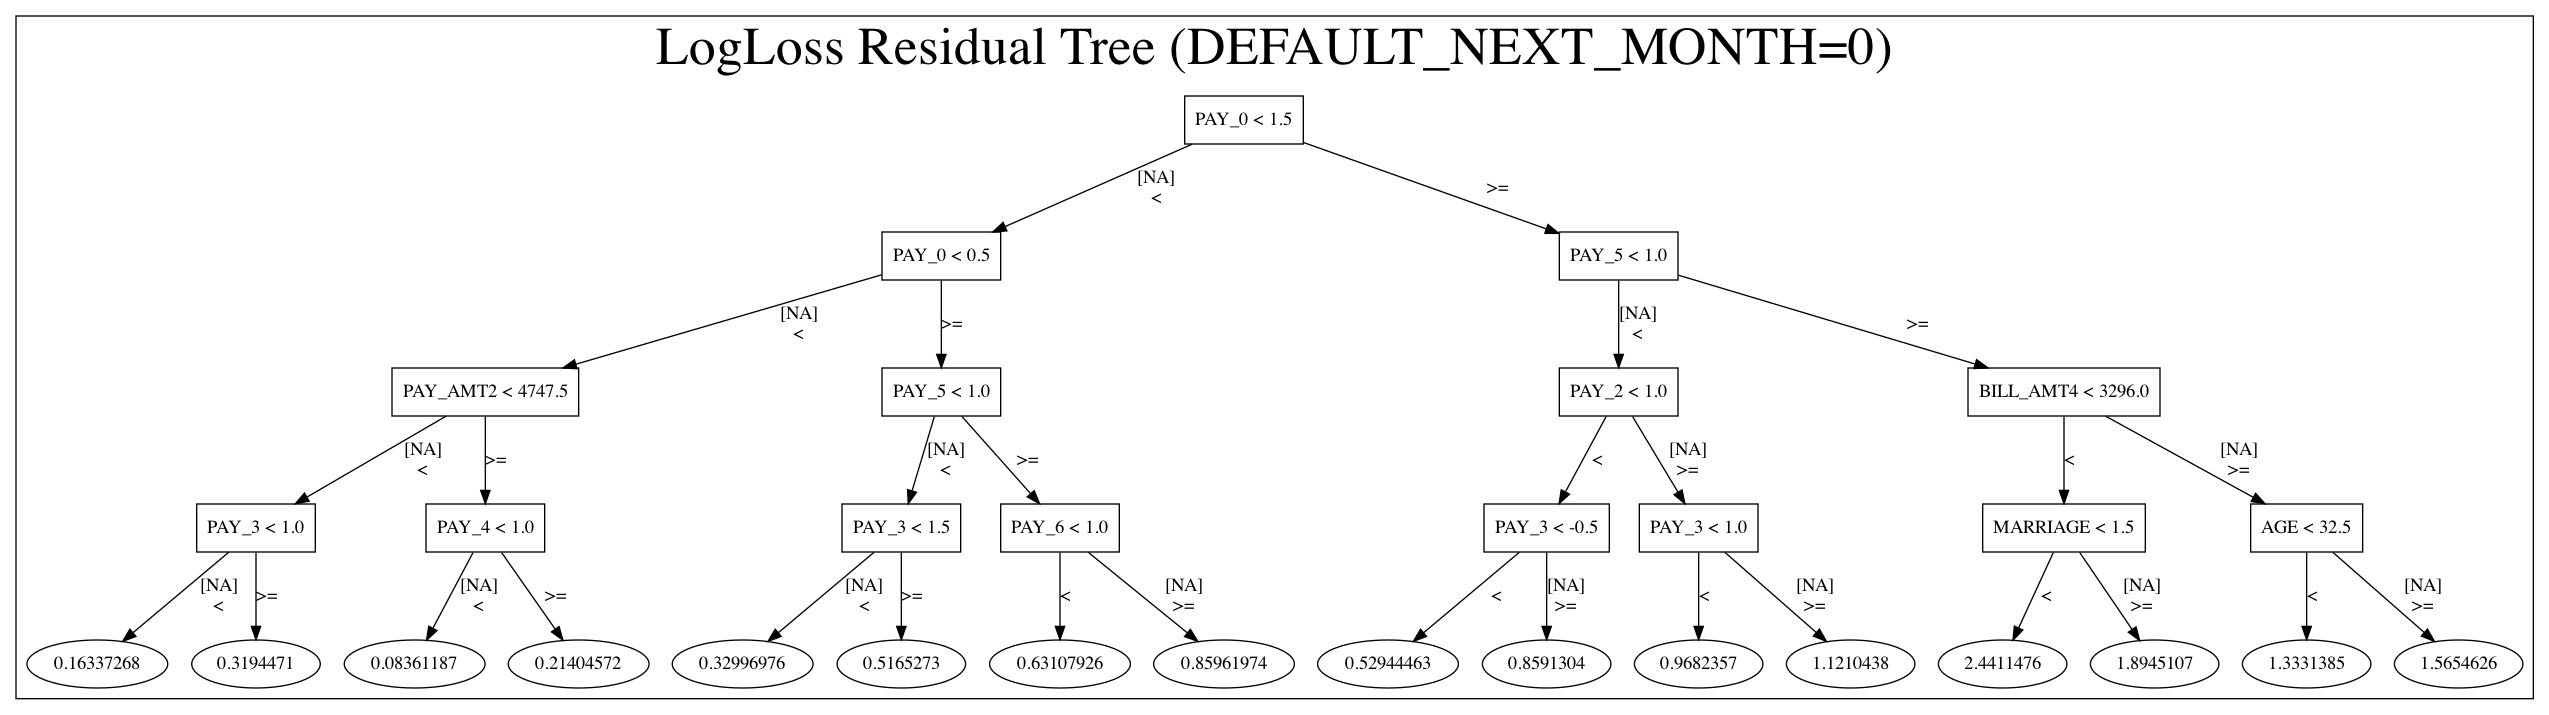

In [44]:
display(Image(('tree0.png')))

This relatively accurate tree shows that strong patterns likely exist in the model residuals for non-default decisions. The highest residuals appear to occur when: `PAY_0 >= 1.5` and `PAY_5 >= 1` and `BILL_AMT2 < 18776.5` and `PAY_4 >= 1`. This scenario could be easily converted into a *model assertion* for use when scoring new data. When these conditions are present, the model is likely to be wrong and action can be taken such as scoring this individual with another model, diverting them to a human case worker, simply predicting the mean value of `DEFAULT_NEXT_MONTH`, or injecting missing values into their data in hopes of issuing a better prediction. 

Since these residuals relate to individuals being awarded a loan, another potentially important pattern to be aware of in the residuals would be if employees, contractors, or consultants were consistently being awarded loans, particularly by high-residual model decisions. Such a pattern could be indicative of data poisoning or tampering with model scoring logic. It seems possible that these tree rules could also be used to create adversarial examples for white-hat hacking purposes.

#### Decision tree for `DEFAULT_NEXT_MONTH` = 1 logloss residuals

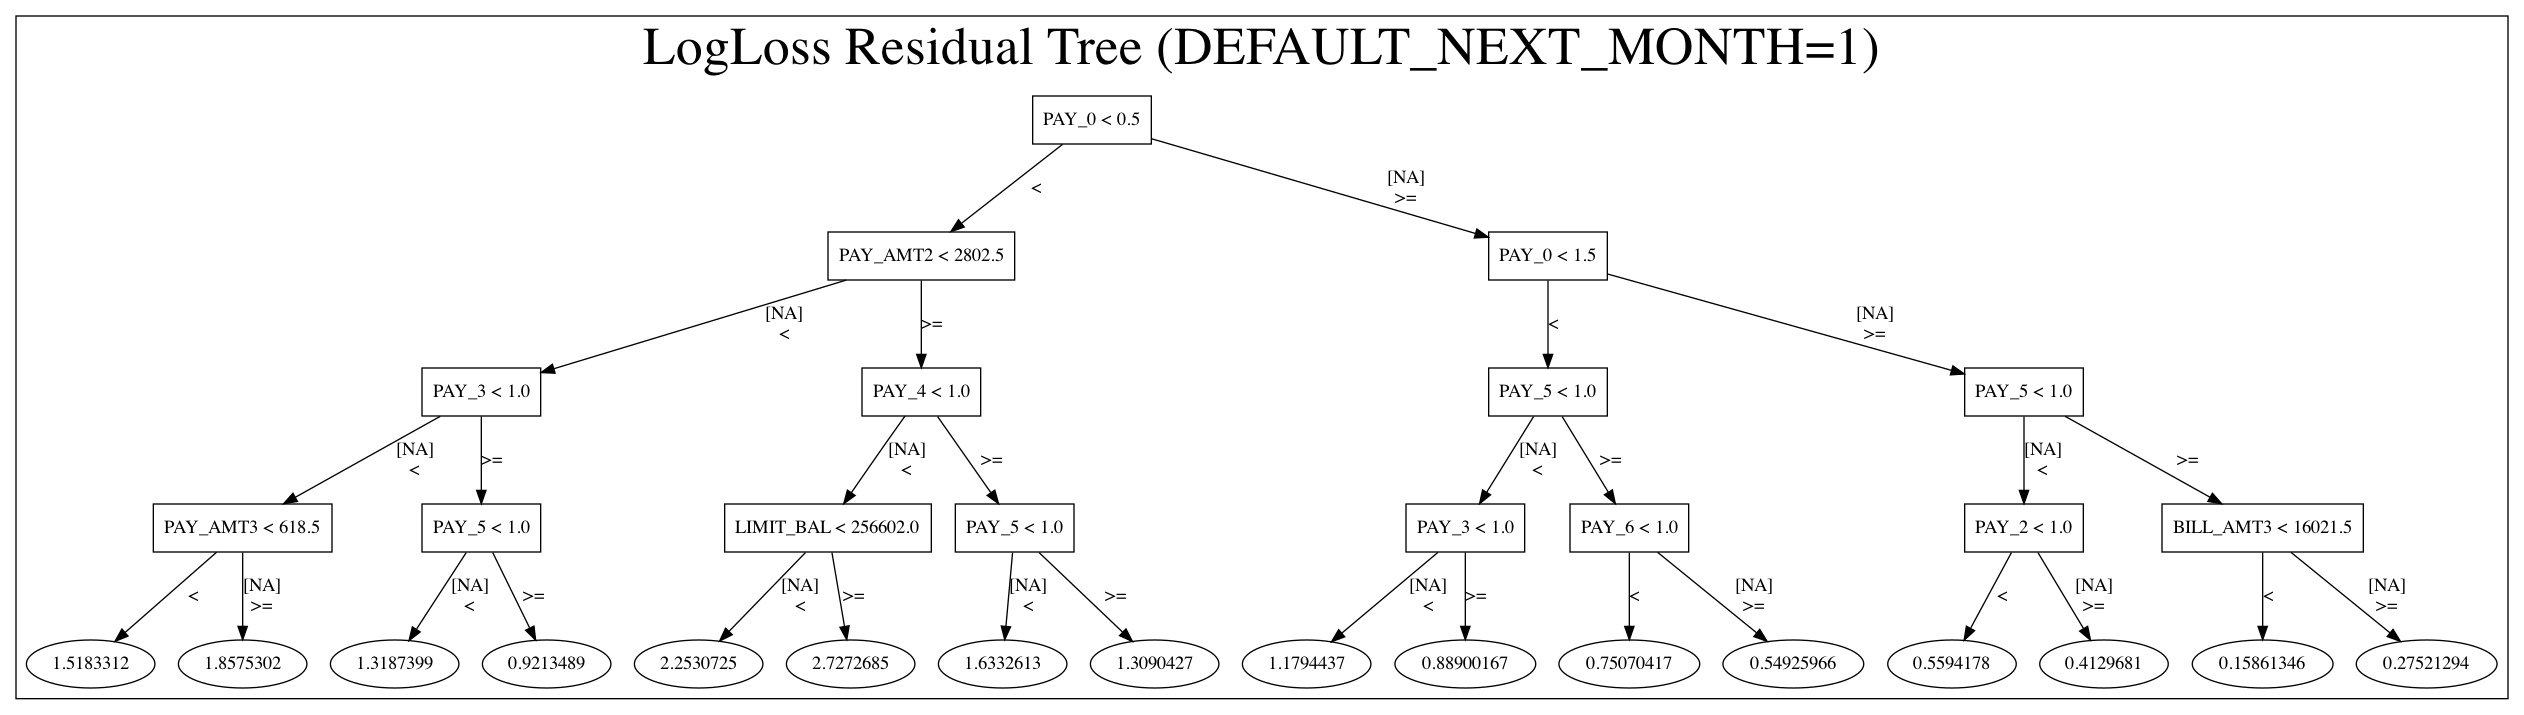

In [45]:
display(Image(('tree1.png')))

This relatively accurate tree shows that strong patterns likely also exist in the model residuals for default decisions. Rules of this tree could be used to create model assertions as well, and because the decisions of this tree result in denial of credit, any rules relating demographic variables to large residuals may be indicative of sociological bias in model predictions.

#### Conclusion

This notebook uses techniques related to residual analysis to: 

* Visualize residuals and learn about outlying, wrong predictions and to see that the trained model is too dependent on one input variable: `PAY_0`.

* Examine multiple types of errors across the levels of categorical variables and found that the model behaves poorly for `PAY_0 >= 2` but seems to have roughly similar error characteristics across men and women.

* Compare monotonic GBM predictions to simpler linear model predictions and discovered a group of customers for which the simpler linear model performs better than the GBM.

* Analyze residuals with post-hoc explainable AI techniques to understand:

  * Shapley contributions to predictions and to the GBM model's logloss, and to see that some variables are actually more important globally to the logloss than to the predictions.
  * Shapley prediction contributions and their relationships to the model residuals, and discovered that some Shapley contribution values are only associated with correct model decisions.
  * Local Shapley contributions to logloss and to view the exact local contributions of variables to logloss for a high-residual individual.
  * Summaries of residual behavior through decision trees and potentially to create model assertions or adversarial examples automatically.

Once these kinds of model bugs have been identified, new options exist to remediate them during either training or scoring. This model was found to be too dependent on `PAY_0` and there was remaining signal in the model residuals to train accurate decision trees. It seems there is additional information that would lessen this model's over-emphasis of `PAY_0` and perhaps allow the constrained GBM to make more accurate decisions in general. Local contributions to logloss were also calculated. Is it possible to retrain the model with this information in some kind of novel row and column boosting scheme? Can the Shapley prediction contributions and the decision tree rules for residuals be used to create model assertions automatically? More importantly than this one toy case, can these strategies be applied to find accuracy, fairness, or security bugs in different types of models?